# Его величество, "домашка №1"

В этой домашней работе вам предоставится уникальная возможность обучить Byte-level BPE токенизатор и небольшую LM.  

Домашняя работа состоит из нескольких последовательных блоков: реализация и обучение токенизатора, реализация Transformer модели и обучение модели на датасете с русскими анекдотами!

Обученные токенизатор и модель можно и нужно выложить на [🤗 HuggingFace](https://huggingface.co/). Зарегистрируйтесь там, подпишитесь на [deep vk](https://huggingface.co/deepvk) и создайте себе API токен.

Следуйте ячейкам тетрадки и заполняйте пропущенные ячейки. В конце тетрадки вы найдете задачи со звездочкой, чтобы получить максимальный балл!

In [ ]:
# colab_llm

In [2]:
# Установим необходимые дополнительные библиотеки

%pip install --quiet datasets livelossplot

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Необходимые импорты

import inspect
import json
import os
from collections import Counter
from dataclasses import dataclass
from functools import lru_cache, partial
from pathlib import Path

import regex as re
import torch
import torch.nn as nn
from datasets import load_dataset
from huggingface_hub import HfApi, PyTorchModelHubMixin, interpreter_login, snapshot_download
from huggingface_hub.utils import SoftTemporaryDirectory
from livelossplot import PlotLosses
from torch import Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange

import time
import gc

In [4]:
# Этой функцией будут помечены все места, которые необходимо дозаполнить
# Это могут быть как целые функции, так и отдельные части внутри них
# Всегда можно воспользоваться интроспекцией и найти места использования этой функции :)


def todo():
    stack = inspect.stack()
    caller_frame = stack[1]
    function_name = caller_frame.function
    line_number = caller_frame.lineno
    raise NotImplementedError(f"TODO at {function_name}, line {line_number}")

In [5]:
interpreter_login()


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|



Enter your token (input will not be visible):  ········
Add token as git credential? (Y/n)  Y


Token has not been saved to git credential helper.


Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub.
Run the following command in your terminal in case you want to set the 'store' credential helper as default.

git config --global credential.helper store

Read https://git-scm.com/book/en/v2/Git-Tools-Credential-Storage for more details.


In [6]:
# Подготовим репозиторий для будущей модели и токенизатора
username = HfApi().whoami()["name"]
REPO_NAME = f"{username}/llm-course-hw1"  # Или как вам хочется

print(f"Homework repository: '{REPO_NAME}'")

# И другие полезные вещи
SEED = 0xC0FFEE

Homework repository: 'Dayara13/llm-course-hw1'


# Датасет

Первым делом загрузим данные: [🤗 IgorVolochay/russian_jokes](https://huggingface.co/datasets/IgorVolochay/russian_jokes)

И немного посмотрим на них 👀

In [7]:
dataset = load_dataset("IgorVolochay/russian_jokes")
print("\n===\n".join(dataset["train"]["text"][:3]))

README.md:   0%|          | 0.00/99.0 [00:00<?, ?B/s]

dataset.txt:   0%|          | 0.00/41.7M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/150553 [00:00<?, ? examples/s]

- Зять, а ты знаешь, где найти того мужчину, который спас меня, когда я тонула?- Да, он уже приходил ко мне извиняться!
===
После проведения акции "К животным по-человечески" животные посовещались и решили провести акцию "К человеку по-скотски".
===
Штирлиц пришел домой и сразу завалился на боковую. Средняя от досады заплакала.


In [8]:
# Подготовим холдауты
dataset = dataset["train"].train_test_split(test_size=0.1, seed=SEED)
dataset

DatasetDict({
    train: Dataset({
        features: ['text'],
        num_rows: 135497
    })
    test: Dataset({
        features: ['text'],
        num_rows: 15056
    })
})

# Токенизатор [6 баллов]

В качестве токенизатора будем использоват Byte-level BPE.

Для этого:
1. Реализуем его обучения, нам необходимо построить словарь заданного размера и набор слияний по этому словарю
2. Обучим токенизатор на датасете
3. Реализуем инференс токенизатора: кодирование текста и декодирование токенов


In [9]:
# Всякие полезности

WHITESPACE_SPLITTER = re.compile(r"""'s|'t|'re|'ve|'m|'ll|'d| ?\p{L}+| ?\p{N}+| ?[^\s\p{L}\p{N}]+|\s+(?!\S)|\s+""")


def bytes_to_unicode() -> dict[int, str]:
    """The original dictionary consists of 256 bytes and their corresponding Unicode characters.
    For example, chr(33) is '!'. However, not all bytes have a visually appealing representation,
    so such characters are skipped and replaced with the first available ones, i.e. shifted by 256.
    """
    initial_bytes = (
        list(range(ord("!"), ord("~") + 1)) + list(range(ord("¡"), ord("¬") + 1)) + list(range(ord("®"), ord("ÿ") + 1))
    )
    initial_chars = [chr(it) for it in initial_bytes]
    n = 0
    for byte in range(2**8):
        if byte not in initial_bytes:
            initial_bytes.append(byte)
            initial_chars.append(chr(2**8 + n))
            n += 1
    return dict(sorted(zip(initial_bytes, initial_chars)))

In [ ]:
# # words_by_tokens = Counter({("a", "b", "b", "c", "b", "c", "b", "c", "a"):2, ("a", "b", "c", "a", "a", "b", "c", "b", "c"):1})
# words_by_tokens = Counter({('a', 'b', 'bc', 'bc', 'bc', 'a'):2, ('a', 'bc', 'a', 'a', 'bc', 'bc'):1})
# # merge_pair = ("b", "c")
# merge_pair = ("bc", "bc")
# pair_frequences = Counter()
# for tokens, freq in words_by_tokens.items():
#     for i in range(len(tokens) - 1):
#         pair_frequences[(tokens[i], tokens[i+1])] += freq
# del pair_frequences[pair_frequences.most_common(1)[0][0]]
# pf, wbt = merge(merge_pair, pair_frequences, words_by_tokens)
# pair_frequences = Counter()
# for tokens, freq in wbt.items():
#     for i in range(len(tokens) - 1):
#         pair_frequences[(tokens[i], tokens[i+1])] += freq
# pf == pair_frequences, wbt

(True,
 Counter({('a', 'b', 'bcbc', 'bc', 'a'): 2, ('a', 'bc', 'a', 'a', 'bcbc'): 1}))

In [2]:
from collections import Counter

def merge(merge_pair: tuple[str, str], pair_frequences: Counter[tuple[str, str]], words_by_tokens: Counter[tuple[str]]):
    """Merges a given pair of tokens and update corresponding stats

    Args:
        merge_pair: The pair of tokens to be merged.
        pair_frequences: A counter tracking the frequency of token pairs in the dataset.
        words_by_tokens: A counter mapping tokenized words to their frequencies.

    Returns:
        Updated pair frequences and word tokenization w.r.t. to new token.
    """
    new_words_by_tokens = Counter()
    for tokens, freq in words_by_tokens.items():
        new_tokens = list()
        prev_add = False
        tokens_size = len(tokens)
        tokens_pos = 0
        for i in range(tokens_size - 1):
            if prev_add:
                pair_frequences[(merge_pair[1], tokens[i+1])] -= freq
                pair_frequences[(merge_pair[0] + merge_pair[1], tokens[i+1])] += freq
                prev_add = False
                continue
            if tokens[i] == merge_pair[0] and tokens[i+1] == merge_pair[1]:
                if tokens_pos > 0:
                    pair_frequences[(new_tokens[tokens_pos-1], merge_pair[0])] -= freq
                    pair_frequences[(new_tokens[tokens_pos-1], merge_pair[0] + merge_pair[1])] += freq
                new_tokens.append(merge_pair[0] + merge_pair[1])
                tokens_pos += 1
                prev_add = True
                continue
            new_tokens.append(tokens[i])
            tokens_pos += 1
        if not prev_add:
            new_tokens.append(tokens[tokens_size-1])

        new_words_by_tokens[tuple(new_tokens)] = freq

    pair_frequences += Counter()

    return pair_frequences, new_words_by_tokens


def train(data: list[str], vocab_size: int = 1024, special_tokens: list[str] = None):
    """Train BPE tokenizer on passed data

    Args:
        data: List of train documents
        vocab_size: Size of target vocabulary
        special_tokens: List of special tokens to add into vocabulary
    Returns:
        vocabulary: mapping from string token to id
        merges: list of merges, each one is tuple of string tokens
    """
    if vocab_size < 256:
        raise ValueError("Vocab size can't be less than 256")
    if special_tokens is None:
        special_tokens = []

    # 1. Initialize vocabulary (using inverse one during training)
    id2token = bytes_to_unicode()
    merges = []

    # 2. Load data
    words_by_tokens = Counter()
    for sample in tqdm(data, desc="Loading data"):
        # 2.1 Split into words
        words = WHITESPACE_SPLITTER.findall(sample.strip())
        for word in words:
            # 2.2 Tokenize with base vocabulary
            words_by_tokens[tuple(map(lambda x: id2token[x], list(word.encode('utf-8'))))] += 1

    # 3. Calculate statistic of token's pairs
    pair_frequences = Counter()
    for tokens, freq in words_by_tokens.items():
        for i in range(len(tokens) - 1):
            pair_frequences[(tokens[i], tokens[i+1])] += freq

    # 4. Build vocabulary
    pbar = trange(vocab_size, desc="Building vocabulary", initial=len(id2token) + len(special_tokens))
    while len(id2token) < vocab_size - len(special_tokens):
        if len(pair_frequences) == 0:
            print("Not enough data to fulfil vocabulary")
            break

        # 4.1 Find the most frequent pair and create new token
        top_pair = pair_frequences.most_common(1)[0][0]
        new_token = top_pair[0] + top_pair[1]
        del pair_frequences[top_pair]

        # 4.2 Add to vocabulary
        if new_token in id2token.values():
            continue
        id2token[len(id2token)] = new_token
        merges.append(top_pair)

        # 4.3 Update stats and merge the top pair in all tokens
        pair_frequences, words_by_tokens = merge(top_pair, pair_frequences, words_by_tokens)

        pbar.update()
    pbar.close()

    # 5. Add special tokens
    for special_token in special_tokens:
        id2token[len(id2token)] = special_token

    return {v: k for k, v in id2token.items()}, merges

In [ ]:
# Обучаем токенизатор на тренировочных текстах
# Для нашей задачи хватит и небольшого словаря, но можете пробовать и большего размера обучить!

vocab, merges = train(dataset["train"]["text"], vocab_size=1024, special_tokens=["[EOS]"])

In [124]:
# vocab = tokenizer.token2id

In [125]:
# Посмотрим на случайные токены

random_tokens = [512, 614, 768, 888, 1022]
unicode_to_bytes = {v: k for k, v in bytes_to_unicode().items()}
for token_id in random_tokens:
    token = [k for k, v in vocab.items() if v == token_id][0]
    raw_bytes = bytes([unicode_to_bytes[it] for it in token])
    print(f"Token #{token_id}: '{raw_bytes.decode('utf-8', errors='replace')}'")

Token #512: ' Я'
Token #614: ' уже'
Token #768: ' Нет'
Token #888: ' него'
Token #1022: ' голов'


In [11]:
class ByteLevelBPETokenizer:

    def __init__(self, vocab: dict[str, int], merges: list[tuple[str, str]], eos_token: str = "[EOS]"):
        """Byte-Level BPE Tokenizer

        Args:
            vocab: mapping from string token to id
            merges: list of merges in prioritized order
            eos_token: string representation of EOS token
        """
        super().__init__()
        if eos_token not in vocab:
            raise ValueError("There is no EOS token in vocab")
        self.byte_encoder = bytes_to_unicode()
        self.byte_decoder = {v: k for k, v in self.byte_encoder.items()}
        self.token2id = vocab
        self.id2token = {v: k for k, v in self.token2id.items()}
        self.eos_token = eos_token
        self.eos_token_id = self.token2id[eos_token]

        # The closer the pair is to the beginning, the higher the rank
        self.merges = merges
        self.bpe_ranks = {pair: i for i, pair in enumerate(merges)}

    @lru_cache
    def bpe(self, word: tuple[str]) -> tuple[str]:
        """Process word into tokenized representation.
        Word is a tuple of base tokens, i.e. bytes.

        Under the hood:
        1. Tracks the set of token pairs, bi-grams
        2. While possible, replaces the highest-ranking pair with its union

        Args:
            word: list of base string tokens
        Return:
            list of BPE tokens
        """
        for merge in self.merges:
            word_upd = list()
            i = 0
            word_ln = len(word)
            while i < word_ln:
                if i < word_ln - 1 and (word[i], word[i+1]) == (merge[0], merge[1]):
                    word_upd.append(merge[0] + merge[1])
                    i += 2
                else:
                    word_upd.append(word[i])
                    i += 1
            word = word_upd
        return word


    def encode(self, text: str, add_eos_token: bool = True) -> list[int]:
        """Convert string to list of token ids.

        Args:
            text: input string, may contain multiple words
            add_eos_token: whether to add eos token id at the end
        Return:
            list of ints, ids of tokenized text
        """
        words = WHITESPACE_SPLITTER.findall(text)
        tokens_ids = list()
        for word in words:
            word_bpe = self.bpe(tuple(map(lambda x: self.id2token[x], list(word.encode('utf-8')))))
            word_bpe_ids = list(map(lambda x: self.token2id[x], word_bpe))
            tokens_ids.extend(word_bpe_ids)
        if add_eos_token:
            tokens_ids.append(self.eos_token_id)
        return tokens_ids

    def decode(self, idx: list[int]) -> str:
        """Convert list of tokens' ids to text, opposite to encode method

        Args:
            idx: list of tokens' ids
        Return:
            string, decoded text
        """
        unicode_bytes = list()
        for token_id in idx:
            if token_id == self.eos_token_id:
                continue
            token = self.id2token[token_id]
            base_tokens = list(token)
            base_unicode = list(map(lambda x: self.byte_decoder[x], base_tokens))
            unicode_bytes.extend(base_unicode)
        text = bytes(unicode_bytes).decode("utf-8")
        return text

    def push_to_hub(self, repo_id, *, private=None, token=None):
        api = HfApi()
        repo_id = api.create_repo(repo_id=repo_id, token=token, private=private, exist_ok=True).repo_id

        # Push the files to the repo in a single commit
        with SoftTemporaryDirectory() as tmp:
            save_directory = Path(tmp) / repo_id
            save_directory.mkdir(parents=True)
            with open(save_directory / "vocabulary.json", "w") as f_out:
                print(json.dumps(self.token2id, indent=2), file=f_out)
            with open(save_directory / "merges.json", "w") as f_out:
                print(json.dumps({"merges": self.merges}), file=f_out)

            return api.upload_folder(repo_id=repo_id, folder_path=save_directory, token=token)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *, token=None, **model_kwargs):
        if not os.path.isdir(pretrained_model_name_or_path):
            storage_folder = snapshot_download(repo_id=pretrained_model_name_or_path, token=token)
        else:
            storage_folder = pretrained_model_name_or_path
        storage_folder = Path(storage_folder)
        with open(storage_folder / "vocabulary.json", "r") as f_in:
            vocab = json.load(f_in)
        with open(storage_folder / "merges.json", "r") as f_in:
            merges = [tuple(it) for it in json.load(f_in)["merges"]]
        return cls(vocab, merges, **model_kwargs)

In [ ]:
# Инициализируем токенизатор


tokenizer = ByteLevelBPETokenizer(vocab, merges)

In [24]:
# Загружаем токенизатор на хаб

tokenizer.push_to_hub(REPO_NAME)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Dayara13/llm-course-hw1/commit/35e2293fe10a75141a5b5b95f94f1b69bf018952', commit_message='Upload folder using huggingface_hub', commit_description='', oid='35e2293fe10a75141a5b5b95f94f1b69bf018952', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Dayara13/llm-course-hw1', endpoint='https://huggingface.co', repo_type='model', repo_id='Dayara13/llm-course-hw1'), pr_revision=None, pr_num=None)

In [12]:
# Скачиваем токенизатор с хаба

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

README.md:   0%|          | 0.00/1.94k [00:00<?, ?B/s]

vocabulary.json:   0%|          | 0.00/37.7k [00:00<?, ?B/s]

.gitattributes:   0%|          | 0.00/1.87k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/119M [00:00<?, ?B/s]

loss.png:   0%|          | 0.00/160k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/162 [00:00<?, ?B/s]

lr.png:   0%|          | 0.00/149k [00:00<?, ?B/s]

merges.json:   0%|          | 0.00/33.1k [00:00<?, ?B/s]

In [13]:
# Смотрим на работу токенизатора

text = "Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре."
ids = tokenizer.encode(text)
print(ids)
reverse_text = [tokenizer.decode([it]) for it in ids]
print("|".join(reverse_text))
print(tokenizer.decode(ids))

[795, 282, 755, 481, 350, 305, 258, 276, 337, 358, 63, 357, 302, 362, 257, 330, 617, 769, 419, 634, 658, 782, 406, 44, 481, 350, 305, 258, 276, 337, 358, 398, 361, 339, 336, 865, 277, 323, 316, 338, 272, 380, 345, 316, 372, 503, 349, 279, 350, 391, 264, 259, 46, 1023]
Ч|то| было| пол|г|од|а| н|аз|ад|?| П|ом|им|о| г|ран|ди|оз|ных| соб|ыт|ий|,| пол|г|од|а| н|аз|ад| бы|ли| е|щ|ё| с|ем|ин|ар|ы| по| л|ин|ей|ной| а|л|г|еб|р|е|.|
Что было полгода назад? Помимо грандиозных событий, полгода назад были ещё семинары по линейной алгебре.


In [14]:
# Посчитаем немного статистики по токенизации, определимся с размером контекста у модели

lens = []
for text in tqdm(dataset["test"]["text"]):
    ids = tokenizer.encode(text)
    lens.append(len(ids))

print(f"Average token len per sample: {sum(lens) / len(lens):.2f}")
print(f"Minimum and maximum lens are: {min(lens)} and {max(lens)}")

  0%|          | 0/15056 [00:00<?, ?it/s]

Average token len per sample: 70.42
Minimum and maximum lens are: 5 and 3324


Должно получиться в среднем по 70 токенов на последовательность.
Контекста в 128 токенов будет вполне достаточно.

# Модель [10 баллов]

В качестве модели реализуем трансформер, в котором
1. В качестве позиционных эмбеддингов используется ALiBi
2. Механизм внимания использует GQA
3. В Feed-Forward блоке SwiGLU

In [15]:
# torch.tril(torch.arange(10).repeat((10, 1)) - torch.arange(10).repeat((10, 1)).T)
# full_mask = torch.full((5, 5), 1)
# casual_mask = torch.tril(full_mask)
# casual_mask
# torch.ones((5, 5, 5)).unsqueeze(-1).shape

# vals, _ = torch.topk(torch.randn(10, 1024), 10, dim=-1)
# vals[:, -1][:, None]

# torch.argmax(torch.arange(10).repeat((2, 1)), dim=-1)

# a = torch.randn(5, 10, 100) * torch.randn(100)
# a.shape

# seq_len = 10
# bias = torch.arange(seq_len).repeat((seq_len, 1))
# bias_matrix = -torch.tril(torch.abs(bias - bias.T))
# bias_matrix

In [19]:
# dim = 512
# ids = torch.arange(0, dim // 2)
# full_ids = torch.zeros(dim, dtype=torch.float)
# full_ids[0::2] = ids
# full_ids[1::2] = ids
# full_ids

In [25]:
# Для удобства заведем конфиг для модели


@dataclass
class TransformerConfig:
    n_layer: int
    n_head: int
    n_kv_head: int
    hidden_dim: int
    intermediate_dim: int
    dropout: float = 0.1
    vocab_size: int = 1024
    max_seq_len: int = 128
    bias: str = "alibi"


model_configs = {
    "nano": TransformerConfig(n_layer=3, n_head=4, n_kv_head=2, hidden_dim=96, intermediate_dim=256),
    "mini": TransformerConfig(n_layer=6, n_head=6, n_kv_head=3, hidden_dim=384, intermediate_dim=1024),
    "small": TransformerConfig(n_layer=12, n_head=12, n_kv_head=6, hidden_dim=768, intermediate_dim=2048),
    "my": TransformerConfig(n_layer=9, n_head=8, n_kv_head=4, hidden_dim=512, intermediate_dim=1536, bias='rope'),
}

In [47]:
class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        """Root Mean Square Layer Normalization

        Args:
            dim: Feature dimension
            eps: Small constant for numerical stability
        """
        super().__init__()
        self.eps = eps
        self.scale = nn.Parameter(torch.ones(dim))

    def forward(self, x: Tensor) -> Tensor:
        # norm_x = torch.sqrt(torch.sum(x * x, dim=-1, keepdim=True) + self.eps)
        norm_x = torch.sqrt(torch.mean(x * x, dim=-1, keepdim=True) + self.eps)
        x = x / norm_x * self.scale
        return x


class CausalSelfAttention(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Causal Self-Attention with support of
        Grouped-Query Attention and ALiBi for positional encoding
        """
        super().__init__()
        self.config = config
        assert self.config.hidden_dim % self.config.n_head == 0
        assert self.config.n_head % self.config.n_kv_head == 0
        assert self.config.bias in ["rope", "alibi"]
        self.head_dim = self.config.hidden_dim // self.config.n_head
        self.scale = self.head_dim**-0.5
        self.q_per_kv = self.config.n_head // self.config.n_kv_head
        self.bias = self.config.bias

        # Init projection layers
        self.q_proj = nn.ModuleList([nn.Linear(config.hidden_dim, self.head_dim, bias=False) for _ in range(config.n_head)])
        # self.kv_proj = nn.ModuleList([nn.Linear(config.hidden_dim, self.head_dim, bias=False) for _ in range(config.n_kv_head)])
        self.k_proj = nn.ModuleList([nn.Linear(config.hidden_dim, self.head_dim, bias=False) for _ in range(config.n_kv_head)])
        self.v_proj = nn.ModuleList([nn.Linear(config.hidden_dim, self.head_dim, bias=False) for _ in range(config.n_kv_head)])
        self.out_proj = nn.Linear(config.hidden_dim, config.hidden_dim, bias=False)

        self.attn_dropout = nn.Dropout(self.config.dropout)

        self.register_buffer("causal_mask", self._create_causal_mask(self.config.max_seq_len))
        self.register_buffer("alibi", self._build_alibi_bias(self.config.n_head))
        self.register_buffer("rope", self._build_rope_bias(self.config.hidden_dim, self.config.max_seq_len))

    def _build_alibi_bias(self, num_heads: int) -> Tensor:
        """Build ALiBi for specified number of heads:

        Returns:
            Tensor with ALiBi biases, shape: [1, num heads, 1, 1]
        """
        alibi_bias = (1/2) * torch.linspace(8/num_heads, 8, num_heads)
        alibi_bias = alibi_bias[None, :, None, None]
        return alibi_bias

    def _create_causal_mask(self, max_seq_len: int) -> Tensor:
        """Create causal mask with ones where tokens can attend to each other.

        Returns:
            Tensor with causal mask, shape: [1, 1, seq len, seq len]
        """
        full_mask = torch.full((max_seq_len, max_seq_len), 1)
        casual_mask = torch.tril(full_mask)[None, None, :, :]
        return casual_mask

    def _build_rope_bias(self, dim: int, max_seq_len: int) -> Tensor:
        """Create rope bias.

        Returns:
            Tensor with rope angles, shape: [1, seq_len, dim]
        """
        ids = torch.arange(0, dim // 2)
        full_ids = torch.zeros(dim, dtype=torch.float)
        full_ids[0::2] = ids
        full_ids[1::2] = ids
        thetas = 10000**(-2*full_ids/dim)[None, None, :]
        seq_ids = torch.arange(1, max_seq_len + 1)[None, :, None]
        rope = seq_ids * thetas
        return rope
        

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Self-Attention to input data with respect to pad tokens.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        device = x.device
        bs = x.shape[0]
        seq_len = x.shape[1]
        if attention_mask is None:
            attention_mask = torch.ones((bs, seq_len), device=device)
        # (bs x n_head x 1 x seq_len)
        attention_mask = attention_mask\
            .unsqueeze(1)\
            .unsqueeze(2)\
            .repeat((1, self.config.n_head, 1, 1))
        if self.bias == "alibi":
            bias = torch.arange(seq_len, device=device).repeat((seq_len, 1))
            bias_matrix = -torch.tril(torch.abs(bias - bias.T))[None, None, :, :]
            alibi_bias = self.alibi * bias_matrix
        else:
            alibi_bias = 0
        q_t, k_t, v_t = list(), list(), list()
        for i in range(self.config.n_head):
            q = self.q_proj[i](x)
            k, v = \
                self.k_proj[i // self.q_per_kv](x), \
                self.v_proj[i // self.q_per_kv](x)
            q_t.append(q)
            k_t.append(k)
            v_t.append(v)
        q_t, k_t, v_t = torch.cat(q_t, dim=-1), torch.cat(k_t, dim=-1), torch.cat(v_t, dim=-1)
        if self.bias == "rope":
            rope_batch = self.rope[:, :seq_len, :]
            change_sign = torch.tensor([-1, 1], device=device)
            q_t_sin = (q_t.reshape(bs, seq_len, -1, 2).roll(1, -1) * change_sign).reshape(bs, seq_len, -1)
            cos_part_q = q_t * torch.cos(rope_batch)
            sin_part_q = q_t_sin * torch.sin(rope_batch)
            q_t = cos_part_q + sin_part_q
            k_t_sin = (k_t.reshape(bs, seq_len, -1, 2).roll(1, -1) * change_sign).reshape(bs, seq_len, -1)
            cos_part_k = k_t * torch.cos(rope_batch)
            sin_part_k = k_t_sin * torch.sin(rope_batch)
            k_t = cos_part_k + sin_part_k
        q_t = q_t.reshape(bs, seq_len, self.config.n_head, -1).transpose(1, 2)
        k_t = k_t.reshape(bs, seq_len, self.config.n_head, -1).transpose(1, 2)
        v_t = v_t.reshape(bs, seq_len, self.config.n_head, -1).transpose(1, 2)
        # relation = torch.matmul(k_t, q_t.transpose(2, 3)) / self.scale + alibi_bias
        # relation = torch.matmul(k_t, q_t.transpose(2, 3)) * self.scale + alibi_bias
        relation = torch.matmul(q_t, k_t.transpose(2, 3)) * self.scale + alibi_bias
        relation = relation.masked_fill(self.causal_mask[:, :, :seq_len, :seq_len] == 0, -torch.inf)
        relation = relation.masked_fill(attention_mask == 0, -torch.inf)
        attn_weights = F.softmax(relation, dim=-1)
        attn_weights = self.attn_dropout(attn_weights)
        attn = torch.matmul(attn_weights, v_t).transpose(1, 2).reshape(bs, seq_len, -1)
        result = self.out_proj(attn)
        return result


class SwiGLU(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Gated Liner Unit with Swish Activation"""
        super().__init__()
        self.config = config
        # Init up- and down- projection layers
        # self.fc1 = todo()
        # self.fc2 = todo()
        self.fc_up = nn.Linear(config.hidden_dim, config.intermediate_dim, bias=False)
        self.fc_gate = nn.Linear(config.hidden_dim, config.intermediate_dim, bias=False)
        self.fc_down = nn.Linear(config.intermediate_dim, config.hidden_dim, bias=False)

    def forward(self, x: Tensor) -> Tensor:
        """Apply SwiGLU to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        x_up = self.fc_up(x)
        x_gate = self.fc_gate(x)
        x_gate = F.sigmoid(x_gate) * x_gate # Swish
        x_before_down = x_gate * x_up
        x_down = self.fc_down(x_before_down)
        return x_down


class Block(nn.Module):
    def __init__(self, config: TransformerConfig):
        """Base Transformer Block
        - Causal Self-Attention and SwiGLU as main elements
        - Pre-normalization via RMSNorm
        - Regularization with dropouts before residuals
        """
        super().__init__()
        self.ln_1 = RMSNorm(config.hidden_dim)
        self.res_dropout_1 = nn.Dropout(config.dropout)
        self.attn = CausalSelfAttention(config)

        self.ln_2 = RMSNorm(config.hidden_dim)
        self.res_dropout_2 = nn.Dropout(config.dropout)
        self.mlp = SwiGLU(config)

    def forward(self, x: Tensor, attention_mask: Tensor = None) -> Tensor:
        """Apply Transformer Block to input data.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            result tensor, shape [bs, seq len, hidden dim]
        """
        x_after_mhsa = self.res_dropout_1(self.attn(self.ln_1(x), attention_mask=attention_mask)) + x
        x_after_mlp = self.res_dropout_2(self.mlp(self.ln_2(x_after_mhsa))) + x_after_mhsa
        return x_after_mlp


class TransformerForCausalLM(nn.Module, PyTorchModelHubMixin):
    def __init__(self, config: TransformerConfig):
        """Transformer model for Language Modeling"""
        super().__init__()
        self.vocab_size = config.vocab_size
        self.max_seq_len = config.max_seq_len
        self.n_layer = config.n_layer
        self.n_head = config.n_head
        self.hidden_dim = config.hidden_dim
        self.dropout = config.dropout

        # self.token_emb = todo()
        self.token_emb = nn.Embedding(config.vocab_size, config.hidden_dim)
        self.emb_dropout = nn.Dropout(config.dropout)
        self.layers = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.ln_final = RMSNorm(config.hidden_dim)
        # self.lm_head = todo()
        self.lm_head = nn.Linear(config.hidden_dim, config.vocab_size, bias=False)

        self.apply(self._init_weights)

        n_params = sum(p.numel() for p in self.parameters())
        print(f"Number of parameters: {n_params / 1e6:.2f}M")

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, RMSNorm):
            torch.nn.init.ones_(module.scale)

    def forward(self, input_ids: torch.Tensor, attention_mask: torch.Tensor = None) -> Tensor:
        """Calculate logits for given input ids.

        Args:
            x: input tensor, shape [bs, seq len, hidden dim]
            attention_mask: mask with zeros for pad tokens, shape [bs, seq len, hidden dim]
        Returns:
            logits, shape [bs, seq len, hidden dim]
        """
        # todo()
        embs = self.emb_dropout(self.token_emb(input_ids))
        for layer in self.layers:
            embs = layer(embs, attention_mask=attention_mask)
        logits = self.lm_head(self.ln_final(embs))
        return logits

    @torch.inference_mode()
    def generate(
        self, idx: Tensor, max_new_tokens, eos_token_id, temperature=1.0, do_sample=False, top_k=None
    ) -> Tensor:
        """Take a conditioning sequence of indices and complete the sequence max_new_tokens times,
        feeding the predictions back into the model each time.

        Args:
            idx: tensor with conditional tokens, shape [seq len]
            max_new_tokens: maximum number of new tokens
            eos_token_id: index of EOS token to stop generation
            temperature, do_sample, top_k: generation parameters
        Return:
            tensor with generated indexes
        """
        for _ in range(max_new_tokens):
            idx_cond = idx if idx.shape[1] <= self.max_seq_len else idx[:, -self.max_seq_len :]
            logits = self(idx_cond)

            # 1. Pluck the logits at the final step and scale by desired temperature
            # logits = todo()
            logits = logits[:, -1, :] / temperature

            # 2. Optionally crop the logits to only the top k options
            if top_k is not None:
                # mask = todo()
                vals_k, _ = torch.topk(logits, top_k, dim=-1)
                min_top_k = vals_k[:, -1][:, None]
                mask = logits < min_top_k
                logits[mask] = -float("inf")

            # 3. apply softmax to convert logits to probabilities
            # probs = todo()
            probs = F.softmax(logits, dim=-1)

            # 4. Either sample from the distribution or take the most likely element
            if do_sample:
                # idx_next = todo()
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                # idx_next = todo()
                idx_next = torch.argmax(logits, dim=-1)[None, :]

            # 5. Append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
            if idx_next == eos_token_id:
                break
        return idx

In [21]:
# gc.collect()
# torch.cuda.empty_cache()

# config = model_configs["my"]
# model = TransformerForCausalLM(config)
# trainer = Trainer(learning_rate=1e-3, n_steps=12_000, val_every_n_steps=1500)
# trainer.run(model, train_dataloader, test_dataloader)

# Train Loop [2 + 2 балла]

Настало время обучать модель.
Небольшую можно пробовать обучать локально, но лучше всего воспользоваться GPU, например, на Google Colab.

За реализацию 2 балла, и еще 2 балла - если модель научилась генерить анекдоты.

Не забудьте проверить, что вы загрузили нужные веса на HF и у проверяющего скачается нужная версия.

In [29]:
# Определим датасет и как заворачивать семплы в батч
# Разные тексты имеют разную длину, поэтому будет падить до самого длина семпла
# Так же заведем дополнительную маску, чтобы механизм внимания не учитывал падинги


class TextDataset(torch.utils.data.Dataset):
    def __init__(self, texts, tokenizer):
        self.texts = texts
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        texts = self.texts[idx]
        tokenized_sequence = self.tokenizer.encode(texts)
        return tokenized_sequence


def data_collator(
    tokenized_sequences: list[list[int]], pad_token_id: int, max_seq_len: int = None
) -> tuple[torch.Tensor, torch.Tensor]:
    batch_size = len(tokenized_sequences)
    max_batch_seq_len = min(max_seq_len, max((len(it) for it in tokenized_sequences)))

    input_ids = torch.full((batch_size, max_batch_seq_len), pad_token_id)
    attention_mask = torch.zeros((batch_size, max_batch_seq_len))

    for i, tok_seq in enumerate(tokenized_sequences):
        cur_len = min(len(tok_seq), max_batch_seq_len)
        input_ids[i, :cur_len] = torch.tensor(tok_seq[:cur_len])
        attention_mask[i, :cur_len] = 1

    return input_ids, attention_mask


def create_dataloader(dataset, pad_token_id, max_seq_len, batch_size, is_train):
    collate_fn = partial(data_collator, pad_token_id=pad_token_id, max_seq_len=max_seq_len)
    return DataLoader(
        dataset, batch_size=batch_size, shuffle=is_train, drop_last=is_train, collate_fn=collate_fn, pin_memory=True
    )


_d = TextDataset(["Привет!", "Как твои дела?", "Осталось совсем немного до конца"], tokenizer)
_dl = create_dataloader(_d, tokenizer.eos_token_id, max_seq_len=16, batch_size=2, is_train=False)

for i, batch in enumerate(_dl):
    print(f"Batch #{i}")
    input_ids, attn_mask = batch
    print(input_ids, attn_mask, sep="\n\n")

Batch #0
tensor([[ 753,  347,  281,   33, 1023, 1023, 1023, 1023],
        [ 530,  304, 1012,  261,  577,  258,   63, 1023]])

tensor([[1., 1., 1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 1., 1., 1., 1.]])
Batch #1
tensor([[ 496,  294,  298,  645,  827,  263,  323,  276,  323,  531,  693,  598,
          881, 1023]])

tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])


In [30]:
def get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps, is_const=False):
    """Scheduler for Optimizer with linear warmup and linear decay to the end of training

    Args:
        optimizer: torch optimizer to control learning rate
        num_warmup_steps: number of warmup steps
        num_training_steps: total number of training steps
    Return:
        torch learning rate scheduler
    """
    assert num_training_steps >= num_warmup_steps

    def lr_lambda(current_step):
        # todo()
        if current_step < num_warmup_steps:
            return (current_step + 1) / num_warmup_steps
        if is_const:
            return 1.0
        return (num_training_steps - current_step + num_warmup_steps) / num_training_steps

    return torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)


def cross_entropy_loss(input_ids: Tensor, attention_mask: Tensor, logits: Tensor) -> Tensor:
    """Calculate Cross-Entropy loss for Language Modeling task
    Under the hood:
    1. Create targtes based on input ids
    2. Masked out tokens corresponded to paddings
    3. Calculate cross entropy loss

    Args:
        input_ids: tensor with input ids, shape [bs, seq len]
        attention_mask: mask with zeros for pad tokens, shape [bs, seq len]
        logits: predicted logits, shape [bs, seq len, vocab size]
    Return:
        cross entropy loss, single-item tensor
    """
    # todo()
    target = input_ids[:, 1:]
    logits = logits[:, :-1, :].transpose(1, 2)
    attention_mask = attention_mask[:, :-1]
    loss = F.cross_entropy(logits, target, reduction='none')
    loss = loss * attention_mask
    loss = loss.sum(dim=-1) / attention_mask.sum(dim=-1)
    loss = loss.mean()
    return loss

In [32]:
# import matplotlib.pyplot as plt
# class Model(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.a = nn.Parameter(torch.ones((10, 10)))

# model = Model()
# opt = torch.optim.SGD(model.parameters(), lr=0.0003)
# num_warmup_steps = 2000
# num_training_steps = 18000
# sch = get_linear_schedule_with_warmup(opt, num_warmup_steps, num_training_steps)

# lrs = list()
# for i in range(num_warmup_steps + num_training_steps):
#     lrs.append(sch.get_last_lr()[0])
#     opt.step()
#     sch.step()

# plt.subplots(1, 1, figsize=(10, 5))
# plt.plot(lrs)
# plt.show()
# print(max(lrs), lrs[num_warmup_steps])

In [33]:
# Определим тренера с наиболее важными гиперпараметрами для обучения


class Trainer:

    def __init__(
        self,
        learning_rate=3e-4,
        weight_decay=0.01,
        clip_grad_norm=1.0,
        n_steps=10_000,
        val_every_n_steps=1_000,
        plot_every_n_steps=100,
    ):
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay
        self.clip_grad_norm = clip_grad_norm
        self.n_steps = n_steps
        self.val_every_n_steps = val_every_n_steps
        self.plot_every_n_steps = plot_every_n_steps

        if torch.cuda.is_available():
            self.device = "cuda"
        elif torch.backends.mps.is_available():
            self.device = "mps"
        else:
            self.device = "cpu"
        print("running on device", self.device)

    @torch.no_grad()
    def validate(self, model, val_loader):
        model.eval()
        val_loss = 0.0
        for batch in tqdm(val_loader, desc="Validating", leave=False):
            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            val_loss += cross_entropy_loss(input_ids, attention_mask, logits)
        return val_loss / len(val_loader)

    def run(self, model, train_loader, val_loader):
        model = model.to(self.device)
        optimizer = torch.optim.AdamW(model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        scheduler = get_linear_schedule_with_warmup(
            optimizer, num_warmup_steps=0.1 * self.n_steps, num_training_steps=self.n_steps, is_const=False
        )
        model.train()

        plotlosses = PlotLosses(figsize=(15, 9), step_names="Step")
        logs = {"lr": 0, "epoch": 0}

        data_iter = iter(train_loader)
        for iter_num in range(self.n_steps):
            try:
                batch = next(data_iter)
            except StopIteration:
                data_iter = iter(train_loader)
                logs["epoch"] += 1
                batch = next(data_iter)

            input_ids, attention_mask = batch
            input_ids = input_ids.to(self.device, non_blocking=True)
            attention_mask = attention_mask.to(self.device, non_blocking=True)

            logits = model(input_ids, attention_mask)  # [bs; seq len; vocab size]
            loss = cross_entropy_loss(input_ids, attention_mask, logits)

            # backprop and update the parameters
            model.zero_grad(set_to_none=True)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), self.clip_grad_norm)
            optimizer.step()
            scheduler.step()

            if iter_num > 0 and iter_num % self.val_every_n_steps == 0:
                val_loss = self.validate(model, val_loader)
                plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
                plotlosses.send()
                model.train()

            if iter_num % self.plot_every_n_steps == 0:
                logs["loss"] = loss.item()
                logs["lr"] = scheduler.get_last_lr()[0]
                plotlosses.update(logs, current_step=iter_num)
                plotlosses.send()

        val_loss = self.validate(model, val_loader)
        plotlosses.update({"val_loss": val_loss.item()}, current_step=iter_num)
        plotlosses.send()

In [35]:
# Создаем тренировочный и тестовые даталоадеры

MAX_SEQ_LEN = 128
BATCH_SIZE = 16

train_dataset = TextDataset(dataset["train"]["text"], tokenizer)
train_dataloader = create_dataloader(
    train_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=True
)

test_dataset = TextDataset(dataset["test"]["text"], tokenizer)
test_dataloader = create_dataloader(
    test_dataset, tokenizer.eos_token_id, max_seq_len=MAX_SEQ_LEN, batch_size=BATCH_SIZE, is_train=False
)

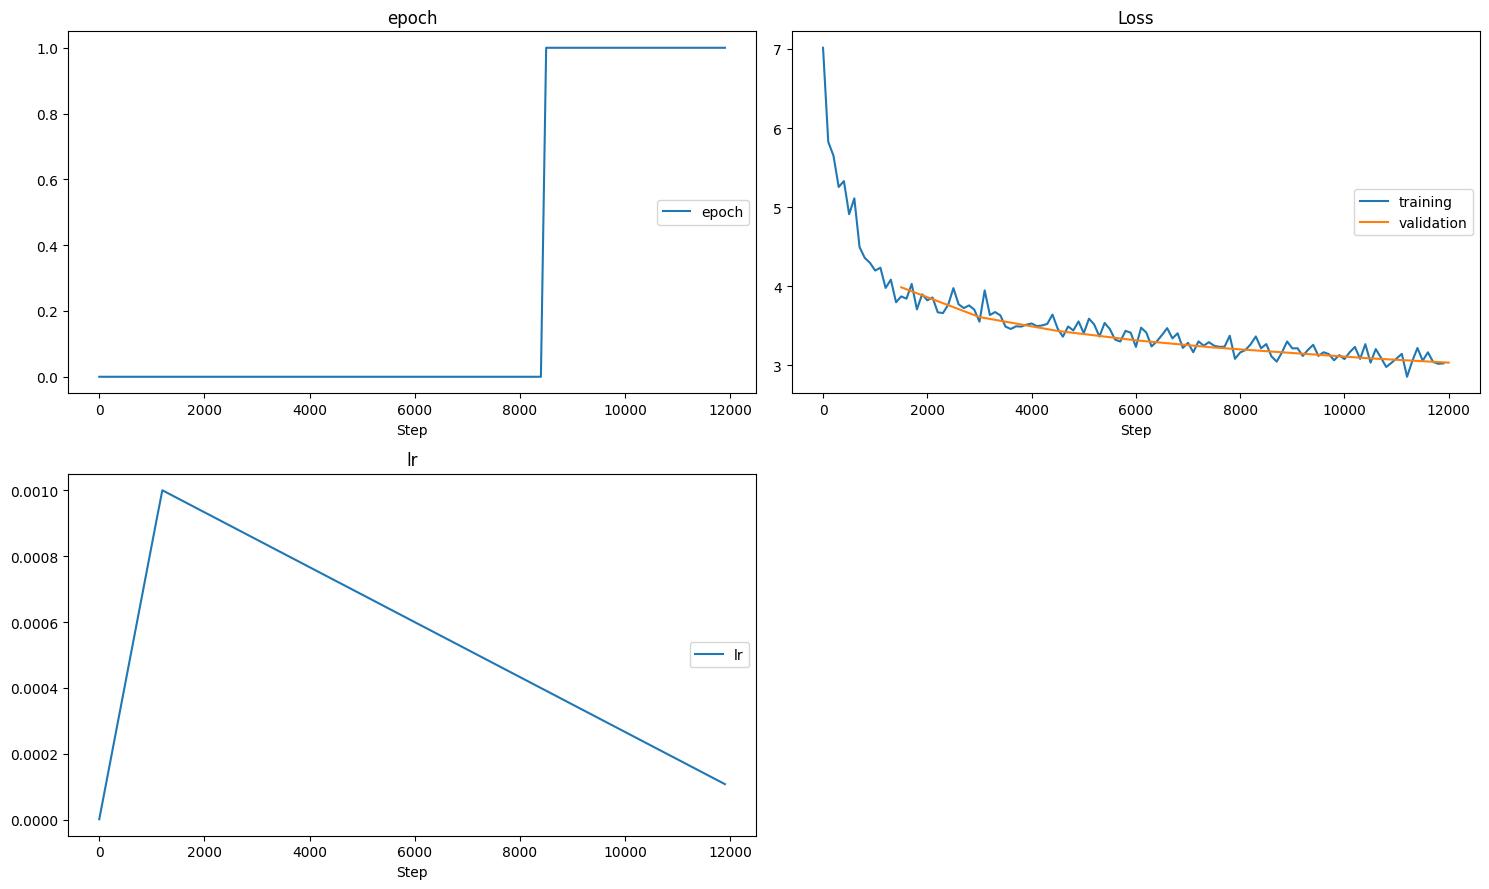

epoch
	epoch            	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    2.857, max:    7.015, cur:    3.027)
	validation       	 (min:    3.036, max:    3.988, cur:    3.036)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [49]:
# LLM with RoPE bias
model_configs["my"].bias = "rope"
config = model_configs["my"]
model = TransformerForCausalLM(config)

trainer = Trainer(learning_rate=1e-3, n_steps=12_000, val_every_n_steps=1500)

trainer.run(model, train_dataloader, test_dataloader)

In [54]:
model.push_to_hub("Dayara13/llm-course-hw1-rope-bias")

model.safetensors:   0%|          | 0.00/121M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/Dayara13/llm-course-hw1-rope-bias/commit/29e11f0a5c58de954d3bfe698cc79350220308c1', commit_message='Push model using huggingface_hub.', commit_description='', oid='29e11f0a5c58de954d3bfe698cc79350220308c1', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Dayara13/llm-course-hw1-rope-bias', endpoint='https://huggingface.co', repo_type='model', repo_id='Dayara13/llm-course-hw1-rope-bias'), pr_revision=None, pr_num=None)

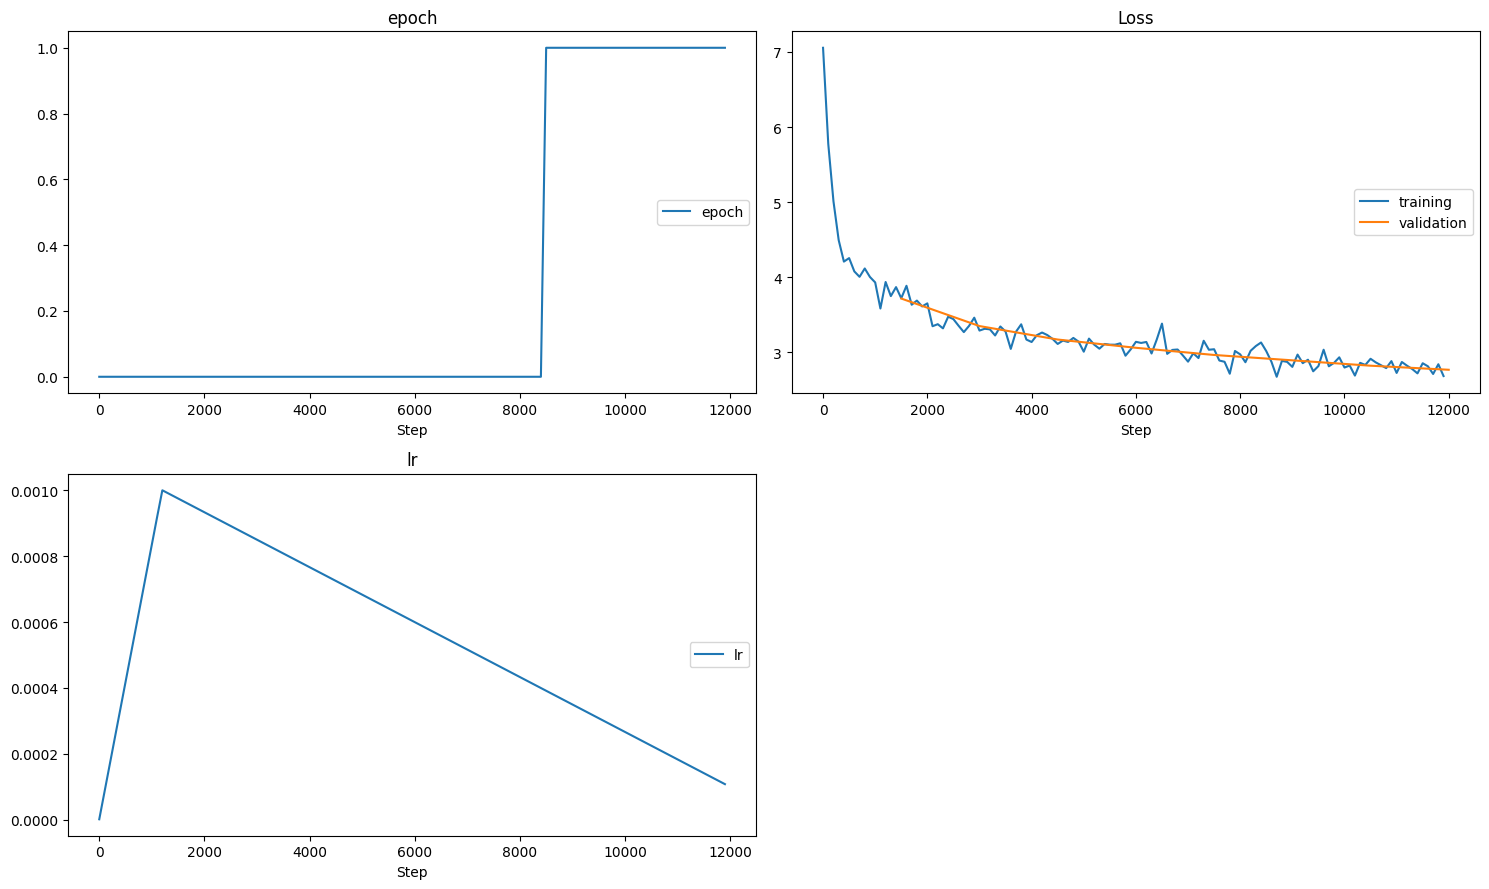

epoch
	epoch            	 (min:    0.000, max:    1.000, cur:    1.000)
Loss
	training         	 (min:    2.676, max:    7.055, cur:    2.685)
	validation       	 (min:    2.769, max:    3.717, cur:    2.769)
lr
	lr               	 (min:    0.000, max:    0.001, cur:    0.000)


In [50]:
# LLM with AliBi bias
model_configs["my"].bias = "alibi"
config = model_configs["my"]
model = TransformerForCausalLM(config)

trainer = Trainer(learning_rate=1e-3, n_steps=12_000, val_every_n_steps=1500)

trainer.run(model, train_dataloader, test_dataloader)

In [57]:
# Смотрим на качество генерации глазами
# Для маленьких и слабых моделей "затягиваем" гайки генерации

text = "Заходит в бар"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=trainer.device)[None, :]
print(input_ids)
model_output = model.generate(
    input_ids, max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=False, top_k=10
)
tokenizer.decode(model_output[0].tolist())

tensor([[730, 258, 620, 275, 303, 338]], device='cuda:0')


'Заходит в бар, а там мужика в кабинет. Вдруг из них спрашивает: - А что это у вас волосы? - Да вот, сынок, это не тот, кто не знает, что он не знает.'

In [39]:
text = "Опять двойка"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=device)
model_output = check_model.generate(
    input_ids[None, :], max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

'Опять двойка - это когда у вас есть два папы.'

In [58]:
# Загружаем модель на хаб

model.push_to_hub(REPO_NAME)

No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/Dayara13/llm-course-hw1/commit/db120f95830c5d49f1cff917c3c0d1546846f440', commit_message='Push model using huggingface_hub.', commit_description='', oid='db120f95830c5d49f1cff917c3c0d1546846f440', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Dayara13/llm-course-hw1', endpoint='https://huggingface.co', repo_type='model', repo_id='Dayara13/llm-course-hw1'), pr_revision=None, pr_num=None)

Поиграйтесь с гиперпараметрами, попробуйте обучить `mini` и `small` версии.
Постарайтесь добиться как можно более высокого качества как в терминах лосса, так и при визуальной оценке генерации.

### Дополнительные баллы

Вы также можно заработать дополнительные баллы:
- Реализовать Rotary Positional Embedding **[4 балла]**
- Реализовать Multi-Head Latent Attention **[2 балл]**
- Оформить репозиторий на 🤗: карточка модели с описанием задания, репортом качества и примерами генерации **[2 балл]**

# Специальный раздел для проверяющего

In [98]:
# Ссылка на карточку модели
# https://huggingface.co/Dayara13/llm-course-hw1

In [31]:
REPO_NAME = "Dayara13/llm-course-hw1"

In [29]:
device = torch.device("cuda")

tokenizer = ByteLevelBPETokenizer.from_pretrained(REPO_NAME)
check_model = TransformerForCausalLM.from_pretrained(REPO_NAME)
check_model = check_model.to(device)
check_model = check_model.eval()

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Number of parameters: 29.37M


In [30]:
text = "Штирлиц пришел домой"
input_ids = torch.tensor(tokenizer.encode(text)[:-1], device=device)
model_output = check_model.generate(
    input_ids[None, :], max_new_tokens=200, eos_token_id=tokenizer.eos_token_id, do_sample=True, top_k=10
)
tokenizer.decode(model_output[0].tolist())

'Штирлиц пришел домой на работу. Подходит мамка на пляж и говорит: "Аллах Криковна-то на кладбище". Тут же мужик и говорит: "А я на работе, сэр! Я же ведь думаю, что с ним в них все равно не придумал.'